In [1]:
!pip install snntorch --quiet

     |████████████████████████████████| 92 kB 627 kB/s 


In [2]:
import snntorch as snn
import torch

# Training Parameters
batch_size=128
data_path='/data/mnist'
num_classes = 10  # MNIST has 10 output classes

# Torch Variables
dtype = torch.float

In [3]:
from torchvision import datasets, transforms

# Define a transform
transform = transforms.Compose([
            transforms.Resize((28,28)),
            transforms.Grayscale(),
            transforms.ToTensor(),
            transforms.Normalize((0,), (1,))])

mnist_train = datasets.MNIST(data_path, train=True, download=True, transform=transform)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to /data/mnist/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to /data/mnist/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to /data/mnist/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to /data/mnist/MNIST/raw



In [4]:
from snntorch import utils

subset = 10
mnist_train = utils.data_subset(mnist_train, subset) # reduces dataset, by a factor of subset
print(f"The size of mnist_train is {len(mnist_train)}")

The size of mnist_train is 6000


mnist_train is now a dataset object with defined transform behavior

train_loader is an iterator divided into batches of size defined in batch_size

In [5]:
from torch.utils.data import DataLoader

train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True)

There are two main methods of feeding data into SNNs as the input has to be feeded in time:

1. At each timestep the same full input is passed into the network
2. Input is converted into a series of spike trains of length num_steps and then passed into network

snn torch offers three ways of data to spike train encoding through ```spikegen``` module:
1. Rate coding ```rate```  (Input features determine spiking frequency)
2. Latency coding ```latency```  (Input features determine spiking timing)
3. Delta modulation ```delta```  (Temporal change of input features generate spikes)

### Rate Coding

We can now create a vector with "features" of 0.5 value to use in encoding

In [6]:
num_steps = 10

raw_vector = torch.ones(num_steps) * 0.5 
print("Raw vector: ", raw_vector)

rate_coded_vector = torch.bernoulli(raw_vector)
print("Rate coded vector: ", rate_coded_vector)

print(f"The output is spiking {rate_coded_vector.sum()*100/len(rate_coded_vector):.2f}% of the time.")

Raw vector:  tensor([0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000])
Rate coded vector:  tensor([1., 0., 1., 1., 1., 1., 0., 1., 0., 0.])
The output is spiking 60.00% of the time.


By the law of big numbers the ratio of spiking to non-spiking will approach 0.5 as num_steps approaches infinity

In [7]:
num_steps = 100

# create vector filled with 0.5
raw_vector = torch.ones(num_steps)*0.5

# pass each sample through a Bernoulli trial
rate_coded_vector = torch.bernoulli(raw_vector)
print(f"The output is spiking {rate_coded_vector.sum()*100/len(rate_coded_vector):.2f}% of the time.")


The output is spiking 59.00% of the time.


Intuitively - fully white pixel will give 100% spike probability and black - 0%.

We can now use spikegen.rate which acts in similar fashion to rate encode example froum our train data loader. 

If feature lies outside of 0, 1 range it will be automatically clipped to correspond to probability.

In [8]:
from snntorch import spikegen

# Iterate through minibatches
data = iter(train_loader)
data_it, targets_it = next(data)

# Spiking Data
spike_data = spikegen.rate(data_it, num_steps=num_steps)

# print("Original data vector: ", data_it)
# print("Rate encoded data vector: ", spike_data)

Input data has a structure of ```batch_size x input_dimensions (color x len x len)``` and rate encoded data is ```num_steps x batch_size x input_dimensions```

In [9]:
print("Original vector size: ", data_it.size())
print("Rate encoded vector size: ", spike_data.size())

Original vector size:  torch.Size([128, 1, 28, 28])
Rate encoded vector size:  torch.Size([100, 128, 1, 28, 28])


#### Animating the input

To deepen our understanding of rate encoding we can use the animator function from ```snntorch.spikeplot``` module

In [10]:
import matplotlib.pyplot as plt
import snntorch.spikeplot as splt
from IPython.display import HTML

In [11]:
spike_data_sample = spike_data[:, 0, 0]
print(spike_data_sample.size())

torch.Size([100, 28, 28])


The corresponding target is: 2


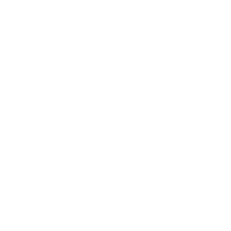

In [12]:
print(f"The corresponding target is: {targets_it[0]}")
fig, ax = plt.subplots(1, 1)
anim = splt.animator(spike_data_sample, fig, ax)
# plt.rcParams['animation.ffmpeg_path'] = 'C:\\path\\to\\your\\ffmpeg.exe'

HTML(anim.to_html5_video())

When dealing with fully white pixels we can tamper with ```gain``` to lower the frequency of spiking

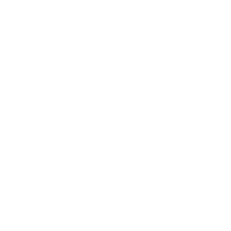

In [13]:
spike_data = spikegen.rate(data_it, num_steps=num_steps, gain=0.25)

spike_data_sample2 = spike_data[:, 0, 0]
fig, ax = plt.subplots()
anim = splt.animator(spike_data_sample2, fig, ax)
HTML(anim.to_html5_video())

By averaging the spiking over time we can do a reconstruction of average input at every time step with different ```gain``` values

In [14]:
plt.figure(facecolor="w")
plt.subplot(1,2,1)
plt.imshow(spike_data_sample.mean(axis=0).reshape((28,-1)).cpu(), cmap='binary')
plt.axis('off')
plt.title('Gain = 1')

plt.subplot(1,2,2)
plt.imshow(spike_data_sample2.mean(axis=0).reshape((28,-1)).cpu(), cmap='binary')
plt.axis('off')
plt.title('Gain = 0.25')

plt.show()

#### Raster plot of neurons spiking

We can also plot the response of every neuron at every time step. This yields a ```width * length x num_steps``` plot. 

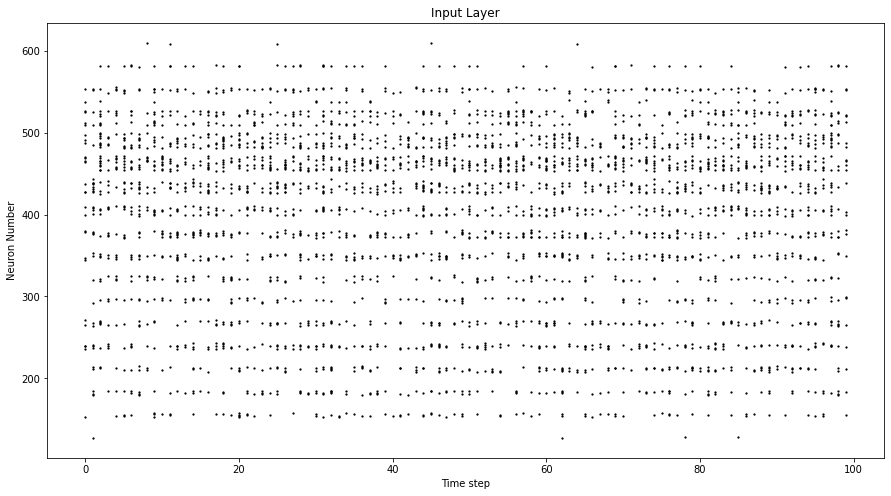

In [15]:
# Reshape
spike_data_sample2 = spike_data_sample2.reshape((num_steps, -1))

# raster plot
fig = plt.figure(facecolor="w", figsize=(15, 8))
ax = fig.add_subplot(111)
splt.raster(spike_data_sample2, ax, s=1.5, c="black")

plt.title("Input Layer")
plt.xlabel("Time step")
plt.ylabel("Neuron Number")
plt.show()

##### Rate encoding conclusion

Even though rate encoding is currently pretty much the only proven paradigm of data encoding in our brain there is a few problems with that, as it probably isn't the only way of global encoding.

**Power consumption:** According to the work of Olshausen and Field's in "What is the other 85%  of V1 doing?", the rate coding would only explain 15% of V1 cortex activity.

**Reaction Response Times:** Average time of our perception window is estimated to be around 250 ms. Given that alfa rhythm is around 10 Hz, we would only be able to process ~2 spikes in that time.



---



Even though, the rate encoding is widely used in SNN world because of good noise robustness and the fact that rate coding is the way of coding information by our sensory modalities.

### Latency Coding

In [16]:
def convert_to_time(data, tau=5, threshold=0.01):
  spike_time = tau * torch.log(data / (data - threshold))
  return spike_time

Relation between features value and time to spike

In [17]:
raw_input = torch.arange(0, 5, 0.05) # tensor from 0 to 5
spike_times = convert_to_time(raw_input)

plt.plot(raw_input, spike_times)
plt.xlabel('Input Value')
plt.ylabel('Spike Time (s)')
plt.show()

We can apply the latency coding to the data by calling ```spikegen.latency``` on batch

```tau``` is the RC time constant, higher tau gives slower firing

```threshold``` value at which the neuron fires

In [18]:
spike_data = spikegen.latency(data_it, num_steps=100, tau=5, threshold=0.01)

In [19]:
fig = plt.figure(facecolor="w", figsize=(10, 5))
ax = fig.add_subplot(111)
splt.raster(spike_data[:, 0].view(num_steps, -1), ax, s=25, c="black")

plt.title("Input Layer")
plt.xlabel("Time step")
plt.ylabel("Neuron Number")
plt.show()

# optional save
# fig.savefig('destination_path.png', format='png', dpi=300)

Above raster plot is clustered because of outliers in black and white, midtones are almost nonexistent so pixels either fire fast or reaaaally slow

Now we can tamper with tau to change that or just use the ```linear=True``` to change the exponential dependance to linear

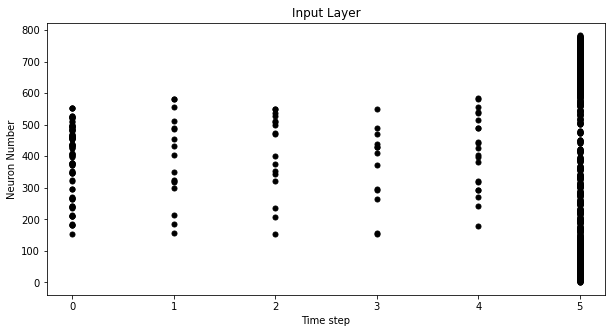

In [20]:
spike_data = spikegen.latency(data_it, num_steps=100, tau=5, threshold=0.01, linear=True)

fig = plt.figure(facecolor="w", figsize=(10, 5))
ax = fig.add_subplot(111)
splt.raster(spike_data[:, 0].view(num_steps, -1), ax, s=25, c="black")
plt.title("Input Layer")
plt.xlabel("Time step")
plt.ylabel("Neuron Number")
plt.show()

We have 100 steps and all firing happens in first 5. To change that we can use ```normalize=True``` and then ```clip=True``` to remove background pixels which would fire last and hold no useful information.

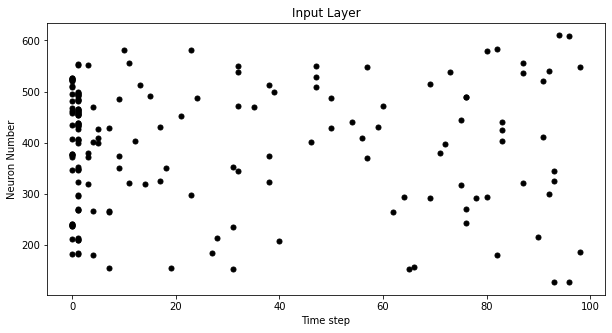

In [21]:
spike_data = spikegen.latency(data_it, num_steps=100, tau=5, threshold=0.01,
                              clip=True, normalize=True, linear=True)

fig = plt.figure(facecolor="w", figsize=(10, 5))
ax = fig.add_subplot(111)
splt.raster(spike_data[:, 0].view(num_steps, -1), ax, s=25, c="black")

plt.title("Input Layer")
plt.xlabel("Time step")
plt.ylabel("Neuron Number")
plt.show()

In [24]:
spike_data_sample = spike_data[:, 0, 0]
print(spike_data_sample.size())
print(targets_it[0])

torch.Size([100, 28, 28])
tensor(2)


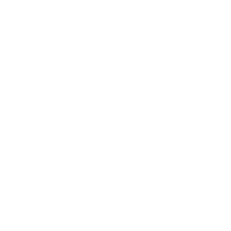

In [23]:
fig, ax = plt.subplots()
anim = splt.animator(spike_data_sample, fig, ax)

HTML(anim.to_html5_video())

### Delta Modulation

To start, we create some fake data to use as an example

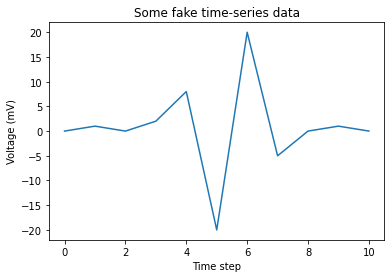

In [25]:
# Create a tensor with some fake time-series data
data = torch.Tensor([0, 1, 0, 2, 8, -20, 20, -5, 0, 1, 0])

# Plot the tensor
plt.plot(data)

plt.title("Some fake time-series data")
plt.xlabel("Time step")
plt.ylabel("Voltage (mV)")
plt.show()

The main premise of delta modulation is compressing time series data into hefty spikes. 

Why?

Dunno

```threshold``` argument defines the change in value which will result in firing 

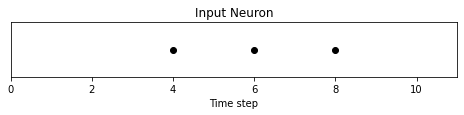

In [26]:
# Convert data
spike_data = spikegen.delta(data, threshold=4)

# Create fig, ax
fig = plt.figure(facecolor="w", figsize=(8, 1))
ax = fig.add_subplot(111)

# Raster plot of delta converted data
splt.raster(spike_data, ax, c="black")

plt.title("Input Neuron")
plt.xlabel("Time step")
plt.yticks([])
plt.xlim(0, len(data))
plt.show()

We can also generate negative spikes by setting ```off_spike=True```

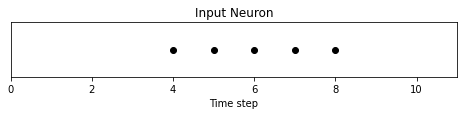

tensor([ 0.,  0.,  0.,  0.,  1., -1.,  1., -1.,  1.,  0.,  0.])


In [29]:
# Convert data
spike_data = spikegen.delta(data, threshold=4, off_spike=True)

# Create fig, ax
fig = plt.figure(facecolor="w", figsize=(8, 1))
ax = fig.add_subplot(111)

# Raster plot of delta converted data
splt.raster(spike_data, ax, c="black")

plt.title("Input Neuron")
plt.xlabel("Time step")
plt.yticks([])
plt.xlim(0, len(data))
plt.show()

print(spike_data)

### Random spike generation

We can also generate some dummy data by calling ```spikegen.rate_conv```

In [30]:
spike_prob = torch.rand((num_steps, 28, 28), dtype=dtype) * 0.5
spike_rand = spikegen.rate_conv(spike_prob)

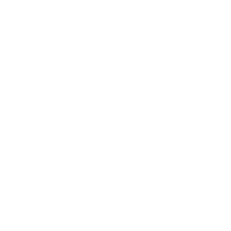

In [31]:
fig, ax = plt.subplots()
anim = splt.animator(spike_rand, fig, ax)

HTML(anim.to_html5_video())

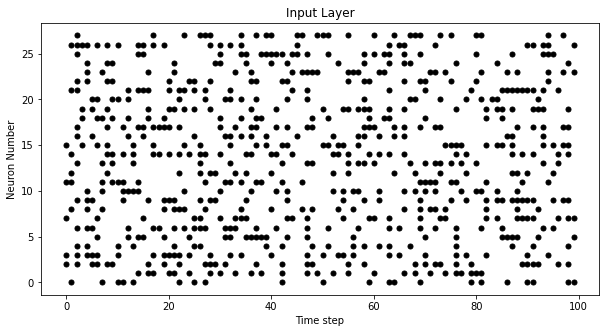

In [32]:
fig = plt.figure(facecolor="w", figsize=(10, 5))
ax = fig.add_subplot(111)
splt.raster(spike_rand[:, 0].view(num_steps, -1), ax, s=25, c="black")

plt.title("Input Layer")
plt.xlabel("Time step")
plt.ylabel("Neuron Number")
plt.show()